In [2]:
import tensorflow as tf
import numpy as np
import copy
import math as math
import time
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
old_v = tf.logging.get_verbosity()
tf.logging.set_verbosity(tf.logging.ERROR)
mnist = input_data.read_data_sets("MNIST_data/",one_hot=True)
tf.logging.set_verbosity(old_v)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


# Part a

In [3]:
X_train = mnist.train.images
Y_train = mnist.train.labels
X_test = mnist.test.images
Y_test = mnist.test.labels

#learning rate
lr = 0.1
#number of maximum traning steps
max_steps = 1000
#number of batch_size
batch_size = 128
num_classes = 10 # number of output features
n_hidden = 300 # number of nodes in hidden layer
lamb = 0.1 # regularization constant

In [28]:
print(np.mean(np.argmax(Y_train, axis =1)==np.argmax(Y_train, axis =1)))

1.0


# Part b

In [4]:
def softmax(X):
    x_softmax = np.zeros(X.shape)
    for i,x in enumerate(X):
        e_x = np.exp(x - np.max(x+1e-10))
        e_x = e_x/e_x.sum()
        x_softmax[i,:] = e_x
    return x_softmax
def relu(z): 
    relu_z = z
    relu_z[relu_z < 0] = 0
    return relu_z
def relu_deriv(z):
    relu_d = z
    relu_d[relu_d <= 0] = 0
    relu_d[relu_d > 0] = 1
    return relu_d
def add_bias(X):
    X_bias = np.ones((X.shape[0], X.shape[1] + 1))
    X_bias[:,1:] = X
    return X_bias
def forward(X,Y, w1,w2):
    a1 = add_bias(X) # n by d+1
    z2 = np.dot(a1, w1) # n by h
    a2 = add_bias(relu(z2)) # n by h+1
    z3 = np.dot(a2, w2) # n by o
    a3 = softmax(z3) # n by o
    return a1, z2, a2, z3, a3
def compute_cost(Y, Y_hat):
    n, o = Y.shape
    running_cost = 0
    entropy= -np.sum(Y*np.log(Y_hat+1e-20), axis = 1);
    return np.mean(entropy)


# Part d

In [7]:
def compute_grad(y,y_hat,a1,z2,a2,z3, w1,w2):
    n = y.shape[0]
    delta = y-y_hat # n by o
    z2_prime = relu_deriv(add_bias(z2)) #n by h+1
    sigmoid = np.dot(delta, w2.T)*z2_prime# n by h+1
    sigmoid = sigmoid[:,1:] # n by h
    dJ_w1 = np.dot(a1.T, sigmoid) # d+1 by h
    dJ_w2 = np.dot(a2.T, delta) # h+1 by o
    dJ_w1[:,1:]+= 2*0.01*w1[:,1:]
    dJ_w2[:,1:]+= 2*0.01*w2[:,1:]
    return dJ_w1, dJ_w2

In [30]:
def gradient_descent(X, Y, X_test, Y_test, learning_rate= 0.01, batch_size = 128,max_steps = 1000):
    n,d = X_train.shape
    m,o = Y_test.shape
    print('Gradient Descent')
    w1 = np.random.uniform(-1.0, 1.0, size = (d+1,n_hidden)) 
    w2 = np.random.uniform(-1.0, 1.0, size = (n_hidden+1,o))
    
    w1_list,w2_list, b1_list,b2_list = [],[],[],[]
    iters, delta = 0, 1e-20
    J_train, J_test = [],[]
    loss_old = 0
    start = time.time()
    while iters < max_steps:
#         print(iters,max_steps)
        w1_old = copy.copy(w1)       
        w2_old = copy.copy(w2)       
        w1_list.append(w1_old)      
        w2_list.append(w2_old)
        l_train, l_test = 0,0
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        a1, z2, a2, z3, y_hat = forward(batch_x, batch_y, w1,w2)
        dJ_w1, dJ_w2 = compute_grad(batch_y,y_hat,a1, z2, a2, z3, w1,w2)

        dJ_w1 = dJ_w1/batch_size
        dJ_w2 = dJ_w2/batch_size
        
        # Back Propogation
        w1 += learning_rate*dJ_w1
        w2 += learning_rate*dJ_w2

        # Compute train and test cost
        a1, z2, a2, z3,y_hat_train = forward(X_train, Y_train,w1,w2)
        a1, z2, a2, z3,y_hat_test = forward(X_test, Y_test,w1,w2)
        l_train = compute_cost(Y_train,y_hat_train)
        l_test = compute_cost(Y_test,y_hat_test)
        J_train.append(l_train)
        J_test.append(l_test)
        
        if iters % 100 == 0:
            print('Current Loss: (iter :', iters+1,')', l_train, l_test)
        if np.mean((w1_old - w1) ** 2)+ np.mean((w2_old - w2) ** 2) < delta:
            break;
        if iters > 100 and np.abs(l_train - loss_old)< 1e-3:
            break;
        loss_old = copy.copy(l_train)
        iters += 1
    end = time.time()
    runtime = end-start
    train_accuracy = np.mean(np.argmax(y_hat_train, axis =1)==np.argmax(Y_train, axis =1))*100.
    test_accuracy = np.mean(np.argmax(y_hat_test, axis =1)==np.argmax(Y_test, axis =1))*100.
                             
    return J_train, J_test, train_accuracy, test_accuracy, runtime


In [31]:
def draw_loss(J_train, J_test, descent_type = ''):
    iterations = range(len(J_train))
    plt.plot(iterations, J_train, label='Loss in train set')
    plt.plot(iterations, J_test, label='Loss in test set')
    plt.xlabel('iteration count')
    plt.ylabel('Loss')
    plt.title('J(w,b) vs. iteration '+descent_type)
    plt.legend()
    plt.show()

Gradient Descent
Current Loss: (iter : 1 ) 36.9484993695 36.7933591731
Current Loss: (iter : 101 ) 9.14335334895 8.94496548452


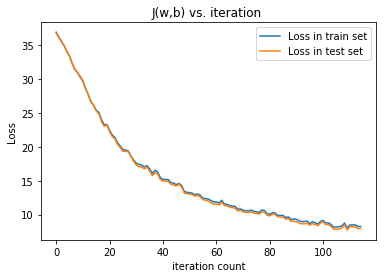

Final Train Accuracy 56.6690909091
Final Test Accuracy 57.74
time spent training:  208.17826199531555
Gradient Descent
Current Loss: (iter : 1 ) 30.788683355 30.9202492471
Current Loss: (iter : 101 ) 7.39681329856 7.22304187632


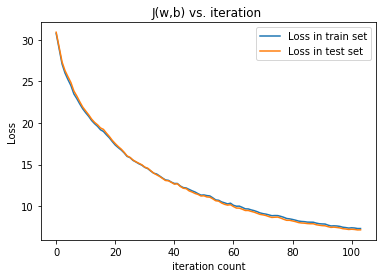

Final Train Accuracy 60.7672727273
Final Test Accuracy 61.5
time spent training:  397.1388449668884
Gradient Descent
Current Loss: (iter : 1 ) 34.6390609094 34.7234068783
Current Loss: (iter : 101 ) 7.8998206943 7.66952827882


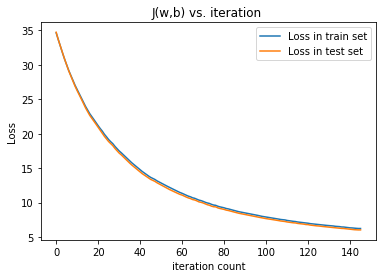

Final Train Accuracy 63.9745454545
Final Test Accuracy 64.38
time spent training:  375.8377139568329
Gradient Descent
Current Loss: (iter : 1 ) 30.196566592 30.2363330827
Current Loss: (iter : 101 ) 7.1103241577 6.58204698264
Current Loss: (iter : 201 ) 4.79222835049 4.31488281929
Current Loss: (iter : 301 ) 3.86714594839 3.469030169
Current Loss: (iter : 401 ) 3.34755056136 3.01498093697


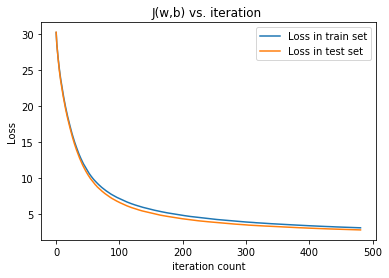

Final Train Accuracy 79.0945454545
Final Test Accuracy 80.54
time spent training:  1863.983587026596


In [33]:
lr = 0.01
batch_size_list = [16, 64, 256, 1024]
n = X_train.shape[0]
for batch_size in batch_size_list:
#     max_steps = n/batch_size+1
    max_steps = 1000
    start = time.time()
    J_train, J_test, train_accuracy, test_accuracy, runtime= gradient_descent(X_train, Y_train ,X_test, Y_test,lr, batch_size,max_steps)
    end = time.time()
    draw_loss(J_train, J_test)
    print('Final Train Accuracy', train_accuracy)
    print('Final Test Accuracy', test_accuracy)
    print('time spent training: ', end-start)

# Part f

In [39]:
def adam_optimizer(dJ_w1, dJ_w2, w1,w2):
    alpha = 0.01
    beta_1 = 0.9
    beta_2 = 0.999
    epsilon = 1e-8
    m1_t, m2_t, v1_t, v2_t, t = 0.,0.,0.,0.,1;
    while True:
        w1_old = copy.copy(w1)       
        w2_old = copy.copy(w2)     
        m1_t = beta_1*m1_t + (1-beta_1)*dJ_w1
        m2_t = beta_1*m2_t + (1-beta_1)*dJ_w2
        v1_t = beta_2*v1_t +(1. - beta_2) * dJ_w1**2
        v2_t = beta_2*v2_t +(1. - beta_2) * dJ_w2**2
        m1_cap = m1_t/(1.-(beta_1**t))
        m2_cap = m2_t/(1.-(beta_1**t))
        v1_cap = v1_t/(1.-(beta_2**t))
        v2_cap = v2_t/(1.-(beta_2**t))
        w1 -= - (alpha*m1_cap)/(np.sqrt(v1_cap)+epsilon)
        w2 -= - (alpha*m2_cap)/(np.sqrt(v2_cap)+epsilon)
        t += 1.0
        if np.mean((w1_old - w1) ** 2)+ np.mean((w2_old - w2) ** 2) < 1e-3:
            break;
    return w1, w2
def gradient_descent_Adam(X, Y, X_test, Y_test, learning_rate= 0.01, batch_size = 128,max_steps = 1000):
    n,d = X_train.shape
    m,o = Y_test.shape
    print('Gradient Descent')
    w1 = np.random.uniform(-1.0, 1.0, size = (d+1,n_hidden)) 
    w2 = np.random.uniform(-1.0, 1.0, size = (n_hidden+1,o))
    
    w1_list,w2_list, b1_list,b2_list = [],[],[],[]
    iters, delta = 0, 1e-20
    J_train, J_test = [],[]
    loss_old = 0
    start = time.time()
    while iters < max_steps:
        w1_old = copy.copy(w1)       
        w2_old = copy.copy(w2)       
        w1_list.append(w1_old)      
        w2_list.append(w2_old)
        l_train, l_test = 0,0
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        a1, z2, a2, z3, y_hat = forward(batch_x, batch_y, w1,w2)
        dJ_w1, dJ_w2 = compute_grad(batch_y,y_hat,a1, z2, a2, z3, w1,w2)

        dJ_w1 = dJ_w1/batch_size
        dJ_w2 = dJ_w2/batch_size
        w1, w2 = adam_optimizer(dJ_w1, dJ_w2, w1, w2)
        a1, z2, a2, z3,y_hat_train = forward(X_train, Y_train,w1,w2)
        a1, z2, a2, z3,y_hat_test = forward(X_test, Y_test,w1,w2)
        l_train = compute_cost(Y_train,y_hat_train)
        l_test = compute_cost(Y_test,y_hat_test)
        J_train.append(l_train)
        J_test.append(l_test)
        if iters % 10 == 0:
            print('Current Loss: (iter :', iters+1,')', l_train, l_test)
        if np.mean((w1_old - w1) ** 2)+ np.mean((w2_old - w2) ** 2) < delta:
            break;
        if iters > 20 and np.abs(l_train - loss_old)< 1e-3:
            break;
        loss_old = copy.copy(l_train)
        iters += 1
    end = time.time()
    runtime = end-start
    train_accuracy = np.mean(np.argmax(y_hat_train, axis =1)==np.argmax(Y_train, axis =1))*100.
    test_accuracy = np.mean(np.argmax(y_hat_test, axis =1)==np.argmax(Y_test, axis =1))*100.
                             
    
    return J_train, J_test,train_accuracy ,test_accuracy, runtime


Batch Size 16
Gradient Descent
Current Loss: (iter : 1 ) 27.2898029395 26.8748539552
Current Loss: (iter : 11 ) 15.1197818238 15.0101325998
Current Loss: (iter : 21 ) 11.0551530692 10.7582622415
Current Loss: (iter : 31 ) 8.18211603855 7.6422641045
Current Loss: (iter : 41 ) 8.88785107392 8.63980369414
Current Loss: (iter : 51 ) 8.29703560485 8.18700836696
Current Loss: (iter : 61 ) 7.88720949241 7.67188779323
Current Loss: (iter : 71 ) 11.3961869299 11.0821797485
Current Loss: (iter : 81 ) 7.99668788178 7.59138756946
Current Loss: (iter : 91 ) 9.25426533697 8.62055317156


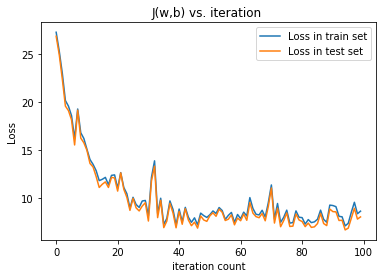

Final Train Accuracy 73.2181818182 %
Final Test Accuracy 74.73 %
Time spent Trainig:  -51.457931995391846
Batch Size 64
Gradient Descent
Current Loss: (iter : 1 ) 28.1414082961 28.2314559353
Current Loss: (iter : 11 ) 9.27451470902 9.05218490074
Current Loss: (iter : 21 ) 7.53615722678 7.31145747729
Current Loss: (iter : 31 ) 5.16093120429 5.03753297723
Current Loss: (iter : 41 ) 4.64235866228 4.46252717999
Current Loss: (iter : 51 ) 4.67329535923 4.62451969139
Current Loss: (iter : 61 ) 3.81231143494 3.81570815934
Current Loss: (iter : 71 ) 4.27724938091 4.3868322299
Current Loss: (iter : 81 ) 4.47749109997 4.34776350056
Current Loss: (iter : 91 ) 4.1984543987 3.99593746481


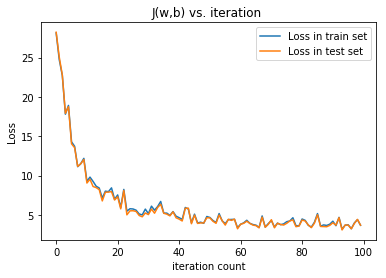

Final Train Accuracy 84.3872727273 %
Final Test Accuracy 83.79 %
Time spent Trainig:  -51.457931995391846
Batch Size 256
Gradient Descent
Current Loss: (iter : 1 ) 31.6832106375 31.5196103283
Current Loss: (iter : 11 ) 7.11306671414 6.81658282159
Current Loss: (iter : 21 ) 6.27700474573 6.20540750304
Current Loss: (iter : 31 ) 4.20407510572 4.1927402215
Current Loss: (iter : 41 ) 3.87621452413 3.72435294223
Current Loss: (iter : 51 ) 2.99078596694 2.90821805544
Current Loss: (iter : 61 ) 3.96684194698 3.9066512577
Current Loss: (iter : 71 ) 2.28961868435 2.19574559619
Current Loss: (iter : 81 ) 2.83647180001 2.8775234389
Current Loss: (iter : 91 ) 2.52459309127 2.46151773951


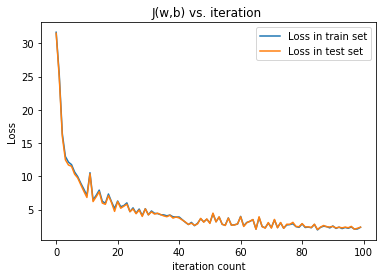

Final Train Accuracy 87.4381818182 %
Final Test Accuracy 87.42 %
Time spent Trainig:  -51.457931995391846
Batch Size 1024
Gradient Descent
Current Loss: (iter : 1 ) 26.1990976917 25.6742941331
Current Loss: (iter : 11 ) 8.43392157118 8.50166582313
Current Loss: (iter : 21 ) 5.92950827275 5.91303754958
Current Loss: (iter : 31 ) 4.76296870604 4.81295320712
Current Loss: (iter : 41 ) 3.96400251556 4.084976792
Current Loss: (iter : 51 ) 3.40676914003 3.58558029301
Current Loss: (iter : 61 ) 3.07414432199 3.22048033073
Current Loss: (iter : 71 ) 2.8631228283 2.97786999105
Current Loss: (iter : 81 ) 2.55349268768 2.79498335165
Current Loss: (iter : 91 ) 1.99991630205 2.23091575587


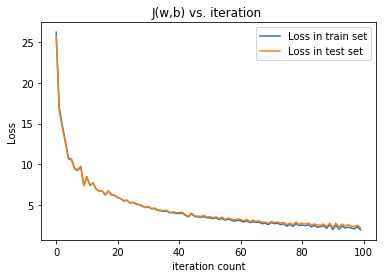

Final Train Accuracy 88.6654545455 %
Final Test Accuracy 88.07 %
Time spent Trainig:  -51.457931995391846


In [40]:
for batch_size in batch_size_list:
    print('Batch Size', batch_size)
    max_steps = 100
    J_train, J_test,train_accuracy ,test_accuracy, runtime = gradient_descent_Adam(X_train, Y_train ,X_test, Y_test,lr, batch_size,max_steps)
    draw_loss(J_train, J_test)
    print('Final Train Accuracy', train_accuracy, '%')
    print('Final Test Accuracy', test_accuracy,'%')
    print('Time spent Trainig: ', end-start)

# Part g

In [41]:
import tensorflow as tf
old_v = tf.logging.get_verbosity()
tf.logging.set_verbosity(tf.logging.ERROR)
#learning rate
lr = 0.01
#number of traning steps
num_steps =1000
#number of batch_size
batch_size = 128

#network parameters
n_hidden = 300
num_input = 784
num_classes = 10

In [42]:
tf.reset_default_graph()

In [46]:
#tf graph input
X = tf.placeholder(tf.float32,[None,num_input],name='X')
Y = tf.placeholder(tf.int32,[None,num_classes],name='Y')

#Layers weight & bias
weights = {
    'W1': tf.Variable(tf.random_normal([num_input, n_hidden]),name='W1'),
    'Wout': tf.Variable(tf.random_normal([n_hidden, num_classes]),name='Wout')
}

biases = {
    'b1': tf.Variable(tf.zeros(shape=[n_hidden]),name='b1'),
    'bout': tf.Variable(tf.zeros(shape=[num_classes]),name='bout')
}
#define a neural net model
def neural_net(x):
    layer_1_out = tf.add(tf.matmul(x,weights['W1']),biases['b1'])
    out = tf.add(tf.matmul(layer_1_out,weights['Wout']),biases['bout'])
    return out
#predicted labels
logits = neural_net(X)
#define loss
loss_generic = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits,labels=Y),name='loss')
#define optimizer
train_op_generic = tf.train.GradientDescentOptimizer(learning_rate=lr).minimize(loss_generic)
#compare the predicted labels with true labels
correct_pred = tf.equal(tf.argmax(logits,1),tf.argmax(Y,1))

#compute the accuracy by taking average
accuracy = tf.reduce_mean(tf.cast(correct_pred,tf.float32),name='accuracy')
lr = 0.01
init = tf.global_variables_initializer()
for batch_size in batch_size_list:
    print('Batch size', batch_size,'=====================')
    start = time.time()
    with tf.Session() as sess:
        sess.run(init)
        for i in range(num_steps):     
            #fetch batch
            batch_x, batch_y = mnist.train.next_batch(batch_size)
            #run optimization
            sess.run(train_op_generic, feed_dict={X:batch_x, Y:batch_y})
            if i % 100 ==0:
                acc = sess.run(accuracy,feed_dict={X:batch_x, Y:batch_y})
                print("step "+str(i)+", Accuracy= {:.3f}".format(acc))
        end = time.time()
        print("Training finished!") 
        print("Train time={:.3f}".format(end-start))
        print("Testing Accuracy: ", sess.run(accuracy, feed_dict={X:mnist.test.images, Y:mnist.test.labels}),'%')
        
        
        

Batch size 16 =====================
step 0, Accuracy= 0.188
step 100, Accuracy= 0.812
step 200, Accuracy= 0.938
step 300, Accuracy= 0.938
step 400, Accuracy= 0.875
step 500, Accuracy= 0.938
step 600, Accuracy= 0.875
step 700, Accuracy= 0.938
step 800, Accuracy= 0.938
step 900, Accuracy= 0.938
Training finished!
Train time=3.508
Testing Accuracy:  0.8469 %
Batch size 64 =====================
step 0, Accuracy= 0.141
step 100, Accuracy= 0.734
step 200, Accuracy= 0.750
step 300, Accuracy= 0.750
step 400, Accuracy= 0.797
step 500, Accuracy= 0.844
step 600, Accuracy= 0.828
step 700, Accuracy= 0.844
step 800, Accuracy= 0.859
step 900, Accuracy= 0.891
Training finished!
Train time=4.200
Testing Accuracy:  0.8545 %
Batch size 256 =====================
step 0, Accuracy= 0.129
step 100, Accuracy= 0.621
step 200, Accuracy= 0.766
step 300, Accuracy= 0.777
step 400, Accuracy= 0.785
step 500, Accuracy= 0.809
step 600, Accuracy= 0.883
step 700, Accuracy= 0.824
step 800, Accuracy= 0.922
step 900, Accur

In [48]:
train_op_Adam = tf.train.AdamOptimizer(learning_rate=lr).minimize(loss_generic)

In [49]:
init = tf.global_variables_initializer()
print('Adam Optimizer')
for batch_size in batch_size_list: 
    print('Batch size', batch_size,'=====================')
    with tf.Session() as sess:
        init = tf.global_variables_initializer()
        sess.run(init)
        start = time.time()
        for i in range(num_steps):
            #fetch batch
            batch_x, batch_y = mnist.train.next_batch(batch_size)
            #run optimization
            sess.run(train_op_Adam, feed_dict={X:batch_x, Y:batch_y})
            
            if i % 100 ==0:
                acc = sess.run(accuracy,feed_dict={X:batch_x, Y:batch_y})
                print("step "+str(i)+", Accuracy= {:.3f}".format(acc))
        end = time.time()
        print("Training finished!") 
        print("Train time={:.3f}".format(end-start))
        print("Testing Accuracy: ", sess.run(accuracy, feed_dict={X:mnist.test.images, Y:mnist.test.labels}),'%')
    

Adam Optimizer
Batch size 16 =====================
step 0, Accuracy= 0.312
step 100, Accuracy= 0.812
step 200, Accuracy= 1.000
step 300, Accuracy= 0.688
step 400, Accuracy= 0.938
step 500, Accuracy= 0.875
step 600, Accuracy= 1.000
step 700, Accuracy= 0.938
step 800, Accuracy= 0.875
step 900, Accuracy= 1.000
Training finished!
Train time=2.611
Testing Accuracy:  0.8485 %
Batch size 64 =====================
step 0, Accuracy= 0.219
step 100, Accuracy= 0.875
step 200, Accuracy= 0.938
step 300, Accuracy= 0.922
step 400, Accuracy= 0.828
step 500, Accuracy= 0.875
step 600, Accuracy= 0.938
step 700, Accuracy= 0.953
step 800, Accuracy= 0.906
step 900, Accuracy= 0.875
Training finished!
Train time=3.536
Testing Accuracy:  0.8866 %
Batch size 256 =====================
step 0, Accuracy= 0.105
step 100, Accuracy= 0.852
step 200, Accuracy= 0.910
step 300, Accuracy= 0.863
step 400, Accuracy= 0.902
step 500, Accuracy= 0.867
step 600, Accuracy= 0.871
step 700, Accuracy= 0.887
step 800, Accuracy= 0.891


The best accuracy acquired by the Numpy Neural Network was 88.07% However, the time it took was 1863 seconds (there was time overflow with Adam Optimizer). The tensorflow had the best accuracy of 89.17% with Adam Optmizer with batch size of 1024 within 20 seconds. 